In [4]:
%pylab inline
from pygadgetreader import *
font = {'size':13, 'family':'serif'}
matplotlib.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


# Computing the CM 

## Basic approach:

In [5]:
# Random points in a sphere:

r = random.random(1000) 
theta = random.random(1000) * 2 - 1
phi = random.random(1000) * 2 * np.pi

x1 = r**(1/3.0) * sin(arccos(theta)) * sin(phi)
y1 = r**(1/3.0) * sin(arccos(theta)) * cos(phi)
z1 = r**(1/3.0) * theta

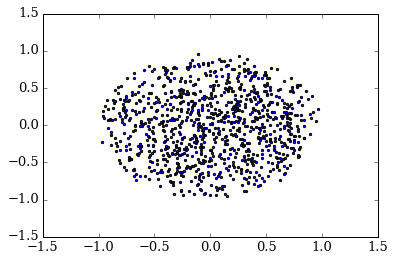

In [6]:
scatter(x1, z1, s=5)

In [7]:
# CM coordinates:
xCM = sum(x1)/len(x1)
yCM = sum(y1)/len(y1)
zCM = sum(z1)/len(z1)

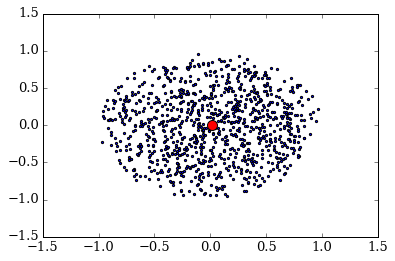

In [8]:
scatter(x1, z1, s=5)
scatter(xCM, zCM, s=100, c='r')

## Iterative approach:


In [74]:
def CM(x, y, z, vx, vy, vz, delta):
    N = len(x)
    xCM = sum(x)/len(x)
    yCM = sum(y)/len(y)
    zCM = sum(z)/len(z)

    xCM_new = xCM
    yCM_new = yCM
    zCM_new = zCM
    
    xCM = 0.0
    yCM = 0.0
    zCM = 0.0
    
    vxCM_new = sum(vx)/N
    vyCM_new = sum(vy)/N
    vzCM_new = sum(vz)/N
    R1 = np.sqrt((x - xCM_new)**2 + (y - yCM_new)**2 + (z - zCM_new)**2)
    Rnow = [max(R1)]

    while (np.sqrt((xCM_new-xCM)**2 + (yCM_new-yCM)**2 +(zCM_new-zCM)**2) > delta):
        xCM = xCM_new#[-1]
        yCM = yCM_new#[-1]
        zCM = zCM_new#[-1]
        Rcm = np.sqrt(xCM**2 + yCM**2 + zCM**2)
        R = np.sqrt((x - xCM)**2 + (y - yCM)**2 + (z - zCM)**2)
        Rmax = max(R)
        index = where(R<Rmax/2.0)
        x = x[index]
        y = y[index]
        z = z[index]
        vx = vx[index]
        vy = vy[index]
        vz = vz[index]
        N = len(x)
        xCM_new=(sum(x)/N)
        yCM_new=(sum(y)/N)
        zCM_new=(sum(z)/N)
        vxCM_new=(sum(vx)/N)
        vyCM_new=(sum(vy)/N)
        vzCM_new=(sum(vz)/N)
        #Rnow.append(max(np.sqrt((x - xCM_new[-1])**2 + (y - yCM_new[-1])**2 + (z - zCM_new[-1])**2)))

        #scatter(xCM_new, yCM_new)

    #print N
    return xCM_new, yCM_new, zCM_new, vxCM_new, vyCM_new, vzCM_new#, Rnow

In [131]:
def CM_disk_potential(x, y, z, vx, vy, vz, Pdisk):
    min_pot = np.where(Pdisk==min(Pdisk))[0]
    x_min = x[min_pot]
    y_min = y[min_pot]
    z_min = z[min_pot]
    avg_particles = np.where(np.sqrt((x-x_min)**2.0 + (y-y_min)**2.0 + (z-z_min)**2.0)<2.0)[0]
    x_cm = sum(x[avg_particles])/len(avg_particles)
    y_cm = sum(y[avg_particles])/len(avg_particles)
    z_cm = sum(z[avg_particles])/len(avg_particles)
    vx_cm = sum(vx[avg_particles])/len(avg_particles)
    vy_cm = sum(vy[avg_particles])/len(avg_particles)
    vz_cm = sum(vz[avg_particles])/len(avg_particles)
    return x_cm, y_cm, z_cm, vx_cm, vy_cm, vz_cm

In [150]:
def computing_MW_CM(path, snap, i_n, i_f, Nhost):
    N_snaps = (i_f - i_n) + 1

    X = np.zeros(N_snaps)
    Y = np.zeros(N_snaps)
    Z = np.zeros(N_snaps)

    VX = np.zeros(N_snaps)
    VY = np.zeros(N_snaps)
    VZ = np.zeros(N_snaps)
    
    Xd = np.zeros(N_snaps)
    Yd = np.zeros(N_snaps)
    Zd = np.zeros(N_snaps)

    VXd = np.zeros(N_snaps)
    VYd = np.zeros(N_snaps)
    VZd = np.zeros(N_snaps)

    time = np.zeros(N_snaps)

    for i in range(i_n, i_f + 1):
        print 'snapshot' + str(i)
        time[i-i_n] = readheader(path + snap + "_{:0>3d}".format(i) ,'time')
        positions = readsnap(path + snap + "_{:0>3d}".format(i) ,'pos', 'dm')
        velocities = readsnap(path + snap + "_{:0>3d}".format(i), 'vel', 'dm')
        particles_ids = readsnap(path + snap + "_{:0>3d}".format(i), 'pid', 'dm')
        potential = readsnap(path + snap + "_{:0>3d}".format(i), 'pot', 'disk')
        positions_d = readsnap(path + snap + "_{:0>3d}".format(i),'pos', 'disk')
        v_d = readsnap(path + snap + "_{:0>3d}".format(i),'vel', 'disk')


        ID = np.sort(particles_ids)
        # The first set of particles are from the host DM halo, the
        # second set are from the satellite DM halo, the limit is know by
        # the number of particles in the host halo.
        idcut = ID[Nhost-1]
        index_mw = np.where(particles_ids<=idcut)
        index_LMC = np.where(particles_ids>idcut)

        x_mw = positions[index_mw[0],0]
        y_mw = positions[index_mw[0],1]
        z_mw = positions[index_mw[0],2]
        x_lmc = positions[index_LMC[0],0]
        y_lmc = positions[index_LMC[0],1]
        z_lmc = positions[index_LMC[0],2]

        vx_mw = velocities[index_mw[0],0]
        vy_mw = velocities[index_mw[0],1]
        vz_mw = velocities[index_mw[0],2]
        vx_lmc = velocities[index_LMC[0],0]
        vy_lmc = velocities[index_LMC[0],1]
        vz_lmc = velocities[index_LMC[0],2]
        
        X[i-i_n], Y[i-i_n], Z[i-i_n], VX[i-i_n], VY[i-i_n], VZ[i-i_n] = CM(x_mw, y_mw, z_mw, vx_mw, vy_mw, vz_mw, 0.1)
        Xd[i-i_n], Yd[i-i_n], Zd[i-i_n], VXd[i-i_n], VYd[i-i_n], VZd[i-i_n] =\
        CM_disk_potential(positions_d[:,0], positions_d[:,1], positions_d[:,2]\
                          , v_d[:,0], v_d[:,1], v_d[:,2], potential)

    return X, Y, Z, VX, VY, VZ, Xd, Yd, Zd, VXd, VYd, VZd


In [152]:
Xcm, Ycm, Zcm, VxCm, VyCm, VzCm, Xd, Yd, Zd, Vxd, Vyd, Vzd = computing_MW_CM('../../data/LMCMW/MWmLMC3/Hernquist/H19/', 'MWfLMC3H19', 0, 100, 100000)


snapshot0
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
snapshot1
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
snapshot2
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
snapshot3
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
snapshot4
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
snapshot5
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
R

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide


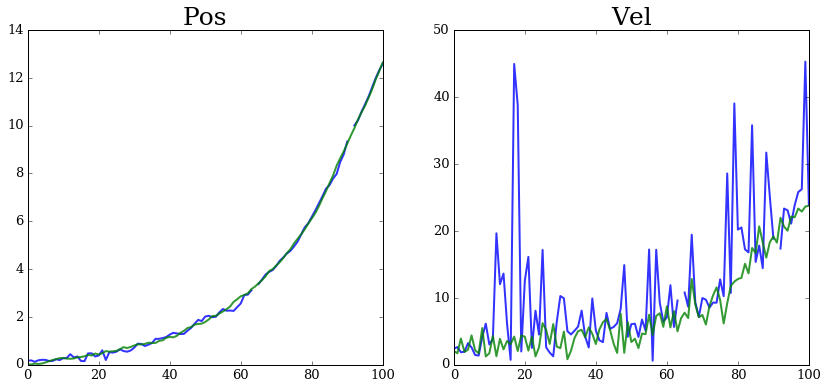

In [133]:
time = np.linspace(0, 2, 100)
figure(figsize=(14,6))
subplot(1, 2, 1)
title('Pos', fontsize=25)
plt.plot(np.sqrt(X_cm**2.0 + Ycm**2.0 + Zcm**2.0), lw=2, alpha=0.8)
plt.plot(np.sqrt(Xd**2.0 + Yd**2.0 + Zd**2.0), lw=2, alpha=0.8)

subplot(1, 2, 2)
title('Vel', fontsize=25)
plt.plot(np.sqrt(VxCm**2.0 + VyCm**2.0 + VzCm**2.0), lw=2, alpha=0.8)
plt.plot(np.sqrt(Vxd**2.0 + Vyd**2.0 + Vzd**2.0), lw=2, alpha=0.8)

# Testing the code in a simulation snapshot:

In [11]:
positions = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pos', 'dm')
velocities = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'vel', 'dm')
particles_ids = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pid', 'dm')
disk = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pos', 'disk')
vdisk = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'vel', 'disk')
bulge = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pos', 'bulge')
vbulge = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'vel', 'bulge')

#potential = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pot', 'dm')



Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Positions
Returning DISK  Velocities
Returning BULGE Positions
Returning BULGE Velocities


### Finging MW DM particles & LMC DM particles

In [12]:
X = sort(particles_ids)
limit = X[29999]
index_mw = where(particles_ids<=49376)
index_LMC = where(particles_ids>49376)

In [13]:
print X
print limit
print len(X)
print int(len(X)/2.0 - 1.0)

[    1     2     3 ..., 79998 79999 80000]
49376
60000
29999


In [14]:
x_sim_mw = positions[index_mw[0],0]
y_sim_mw = positions[index_mw[0],1]
z_sim_mw = positions[index_mw[0],2]

x_sim_lmc = positions[index_LMC[0],0]
y_sim_lmc = positions[index_LMC[0],1]
z_sim_lmc = positions[index_LMC[0],2]

vx_sim_mw = velocities[index_mw[0],0]
vy_sim_mw = velocities[index_mw[0],1]
vz_sim_mw = velocities[index_mw[0],2]

vx_sim_lmc = velocities[index_LMC[0],0]
vy_sim_lmc = velocities[index_LMC[0],1]
vz_sim_lmc = velocities[index_LMC[0],2]

x_disk = disk[:,0]
y_disk = disk[:,1]
z_disk = disk[:,2]

vx_disk = vdisk[:,0]
vy_disk = vdisk[:,1]
vz_disk = vdisk[:,2]

x_bulge = bulge[:,0]
y_bulge = bulge[:,1]
z_bulge = bulge[:,2]

vx_bulge = vbulge[:,0]
vy_bulge = vbulge[:,1]
vz_bulge = vbulge[:,2]


print len(x_sim_mw), len(x_sim_lmc), len(x_disk), len(x_bulge)

30000 30000 10000 10000


(-20, 20)

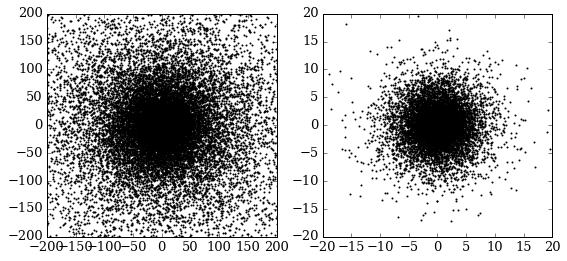

In [15]:
figure(figsize=(14, 4))
subplot(1, 3, 1)
scatter(x_sim_mw, z_sim_mw, s=1.0)
xlim(-200, 200)
ylim(-200, 200)

subplot(1, 3, 2)
scatter(x_disk, y_disk, s=1.0)
xlim(-20, 20)
ylim(-20, 20)

(-200, 200)

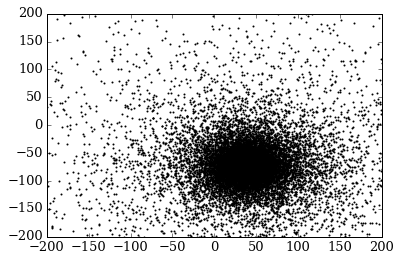

In [16]:
scatter(x_sim_lmc, z_sim_lmc, s=1.0)
xlim(-200, 200)
ylim(-200, 200)

In [17]:
X_sim_mwCM, Y_sim_mwCM, Z_sim_mwCM, vX_sim_mwCM, vY_sim_mwCM, vZ_sim_mwCM, R_sim_MWCM = CM(x_sim_mw, y_sim_mw, z_sim_mw, vx_sim_mw, vy_sim_mw, vz_sim_mw, 0.4)
X_sim_lmcCM, Y_sim_lmcCM, Z_sim_lmcCM, vX_sim_lmcCM, vY_sim_lmcCM, vZ_sim_lmcCM, R_sim_lmcMW  = CM(x_sim_lmc, y_sim_lmc, z_sim_lmc, vx_sim_lmc, vy_sim_lmc, vz_sim_lmc, 0.1)

print X_sim_mwCM[-1], Y_sim_mwCM[-1], Z_sim_mwCM[-1]

-0.134805437164 -0.228039945431 -0.469590179795


In [18]:
X_sim_disk, Y_sim_disk, Z_sim_disk, vX_sim_disk, vY_sim_disk, vZ_sim_disk, R_sim_disk= CM(x_disk, y_disk, z_disk, vx_disk, vy_disk, vz_disk, 0.01)
X_sim_bulge, Y_sim_bulge, Z_sim_bulge, vX_sim_bulge, vY_sim_bulge, vZ_sim_bulge, R_sim_bulge = CM(x_bulge, y_bulge, z_bulge, vx_bulge, vy_bulge, vz_bulge, 0.01)

print len(X_sim_disk)
print len(X_sim_bulge)
print X_sim_disk[-1], Y_sim_disk[-1], Z_sim_disk[-1]
print X_sim_bulge[-1], Y_sim_bulge[-1], Z_sim_bulge[-1]

2
11
-0.0197111796958 0.0490153971321 0.00252089308577
0.0131956816426 0.0182834612276 0.0418945071545


In [19]:
print vX_sim_mwCM[-1], vY_sim_mwCM[-1], vZ_sim_mwCM[-1]
print vX_sim_disk[-1], vY_sim_disk[-1], vZ_sim_disk[-1]
print vX_sim_bulge[-1], vY_sim_bulge[-1], vZ_sim_bulge[-1]

1.35088539679 -0.140483078653 -3.06713958651
-2.22825624559 -0.472409032076 0.0510102072298
0.806298897734 -0.373559706853 0.225122153308


In [20]:
Rcmmw = np.zeros(len(X_sim_mwCM))
Rlmc = np.zeros(len(X_sim_lmcCM))
Rdisk = np.zeros(len(X_sim_disk))
Rbulge = np.zeros(len(X_sim_bulge))

Vcmmw = np.zeros(len(X_sim_mwCM))
Vlmc = np.zeros(len(X_sim_lmcCM))
Vdisk = np.zeros(len(X_sim_disk))
Vbulge = np.zeros(len(X_sim_bulge))

iterationmw = np.zeros(len(X_sim_mwCM))
iterationlmc = np.zeros(len(X_sim_lmcCM))
iterationdisk = np.zeros(len(X_sim_disk))
iterationbulge = np.zeros(len(X_sim_bulge))


for i in range(len(X_sim_mwCM)):
    Rcmmw[i] = np.sqrt(X_sim_mwCM[i]**2 + Y_sim_mwCM[i]**2 + Z_sim_mwCM[i]**2)
    Vcmmw[i] = np.sqrt(vX_sim_mwCM[i]**2 + vY_sim_mwCM[i]**2 + vZ_sim_mwCM[i]**2)
    iterationmw[i] = float(i)

for i in range(len(X_sim_lmcCM)):
    Rlmc[i] = np.sqrt(X_sim_lmcCM[i]**2 + Y_sim_lmcCM[i]**2 + Z_sim_lmcCM[i]**2)
    Vlmc[i] = np.sqrt(vX_sim_lmcCM[i]**2 + vY_sim_lmcCM[i]**2 + vZ_sim_lmcCM[i]**2)
    iterationlmc[i] = float(i)

for i in range(len(X_sim_disk)):
    Rdisk[i] = np.sqrt(X_sim_disk[i]**2 + Y_sim_disk[i]**2 + Z_sim_disk[i]**2)
    Vdisk[i] = np.sqrt(vX_sim_disk[i]**2 + vY_sim_disk[i]**2 + vZ_sim_disk[i]**2)
    iterationdisk[i] = float(i)
    
for i in range(len(X_sim_bulge)):
    Rbulge[i] = np.sqrt(X_sim_bulge[i]**2 + Y_sim_bulge[i]**2 + Z_sim_bulge[i]**2)
    Vbulge[i] = np.sqrt(vX_sim_bulge[i]**2 + vY_sim_bulge[i]**2 + vZ_sim_bulge[i]**2)
    iterationbulge[i] = float(i)

In [21]:
def difference(R):
    Rdif = np.zeros(len(R)-1)
    for i in range(len(R)-1):
        Rdif[i] = abs(R[i+1] - R[i])
    return Rdif

In [22]:
RdifMW = difference(Rcmmw)
Rdiflmc = difference(Rlmc)

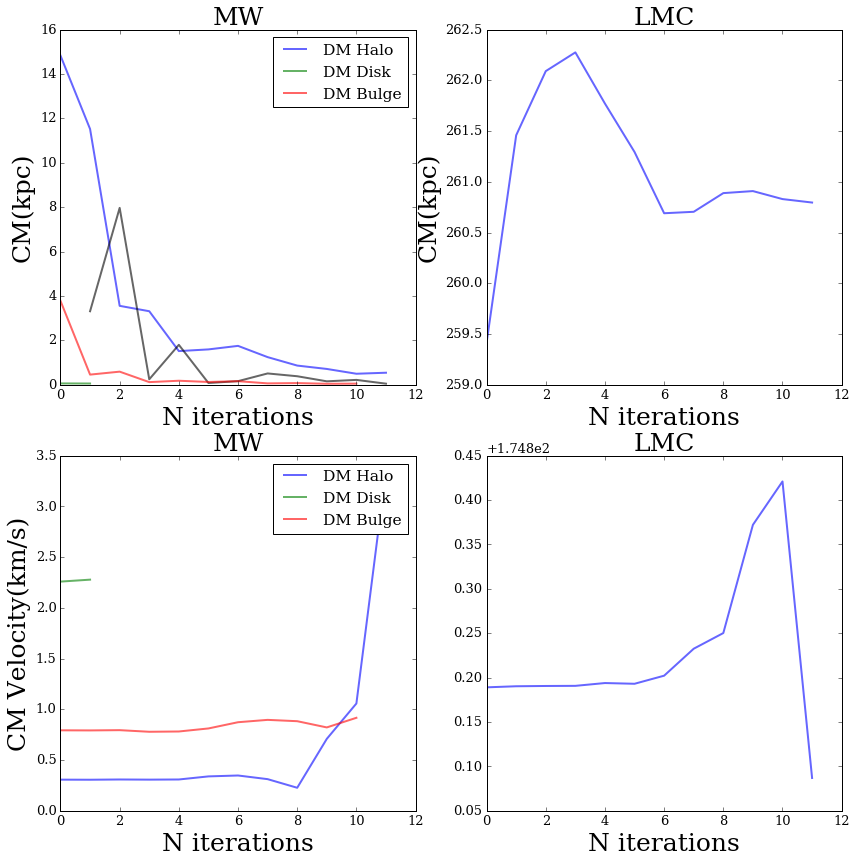

In [23]:
figure(figsize=(14, 14))

subplot(2, 2, 1)
plot(iterationmw, Rcmmw, lw=2, alpha=0.6, label='DM Halo')
plot(iterationmw[1:], RdifMW, lw=2, c='k', alpha=0.6)
plot(iterationdisk, Rdisk, lw=2, alpha=0.6, label='DM Disk')
plot(iterationbulge, Rbulge, lw=2, alpha=0.6, label='DM Bulge')
xlabel('N iterations', fontsize=25)
ylabel('CM(kpc)', fontsize=25)
title('MW', fontsize=25)
legend()

subplot(2, 2, 2)
plot(iterationlmc, Rlmc, lw=2, alpha=0.6)
#plot(iterationlmc[1:], Rdiflmc, lw=2, c='k', alpha=0.6)
xlabel('N iterations', fontsize=25)
ylabel('CM(kpc)', fontsize=25)
title('LMC', fontsize=25)

subplot(2, 2, 3)
plot(iterationmw, Vcmmw, lw=2, alpha=0.6, label='DM Halo')
#plot(iterationmw[1:], VdifMW, lw=2, c='k', alpha=0.6)
plot(iterationdisk, Vdisk, lw=2, alpha=0.6, label='DM Disk')
plot(iterationbulge, Vbulge, lw=2, alpha=0.6, label='DM Bulge')
xlabel('N iterations', fontsize=25)
ylabel('CM Velocity(km/s)', fontsize=25)
title('MW', fontsize=25)
legend()

subplot(2, 2, 4)
plot(iterationlmc, Vlmc, lw=2, alpha=0.6)
#plot(iterationlmc[1:], Vlmc, lw=2, c='k', alpha=0.6)
xlabel('N iterations', fontsize=25)
title('LMC', fontsize=25)


savefig('CM_computation_convergence.png', bbox_inches='tight')


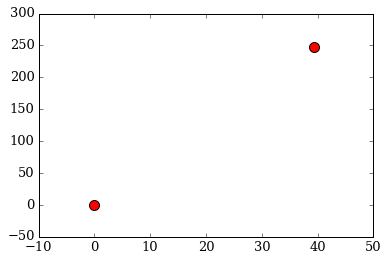

In [24]:
scatter(X_sim_mwCM[-1], Y_sim_mwCM[-1], c='r', s=100)
scatter(X_sim_lmcCM[-1], Y_sim_lmcCM[-1], c='r', s=100)

# Comparing the same snapshot with different resolution, Comparisson with the potential method

In [25]:
def loading_data(filename):
    #potbulge = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pot', 'bulge')
    #posbulge = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pos', 'bulge')
    #velbulge = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'vel', 'bulge')

    pothalos = readsnap(filename, 'pot', 'dm')
    poshalos = readsnap(filename, 'pos', 'dm')
    velhalos = readsnap(filename, 'vel', 'dm')
    idhalos = readsnap(filename, 'pid', 'dm')

    potdisk = readsnap(filename, 'pot', 'disk')
    posdisk = readsnap(filename, 'pos', 'disk')
    veldisk = readsnap(filename, 'vel', 'disk')
    return pothalos, poshalos, velhalos, idhalos, potdisk, posdisk, veldisk


In [26]:
pothalo1, poshalo1, velhalo1, idhalo1, potdisk1, posdisk1, veldisk1 = loading_data("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000")
pothalo2, poshalo2, velhalo2, idhalo2, potdisk2, posdisk2, veldisk2 = loading_data("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000")
pothalo3, poshalo3, velhalo3, idhalo3, potdisk3, posdisk3, veldisk3 = loading_data("MW1LMC4_a1H6UHR_000")

Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities


In [27]:
# -------------------- Low res -----------------

CMDpot1 = where(potdisk1 == min(potdisk1))
XCMdisk1, YCMdisk1, ZCMdisk1 = posdisk1[CMDpot1, 0], posdisk1[CMDpot1, 1], posdisk1[CMDpot1, 2]

Xdisk1, Ydisk1, Zdisk1 = posdisk1[:, 0], posdisk1[:, 1], posdisk1[:, 2]
vXdisk1, vYdisk1, vZdisk1 = veldisk1[:, 0], veldisk1[:, 1], veldisk1[:, 2]

Xhalo1, Yhalo1, Zhalo1 = poshalo1[:, 0], poshalo1[:, 1], poshalo1[:, 2]
vXhalo1, vYhalo1, vZhalo1 = velhalo1[:, 0], velhalo1[:, 1], velhalo1[:, 2]

# -------------------- Med res -----------------

CMDpot2 = where(potdisk2 == min(potdisk2))
XCMdisk2, YCMdisk2, ZCMdisk2 = posdisk2[CMDpot2, 0], posdisk2[CMDpot2, 1], posdisk2[CMDpot2, 2]

Xdisk2, Ydisk2, Zdisk2 = posdisk2[:, 0], posdisk2[:, 1], posdisk2[:, 2]
vXdisk2, vYdisk2, vZdisk2 = veldisk2[:, 0], veldisk2[:, 1], veldisk2[:, 2]

Xhalo2, Yhalo2, Zhalo2 = poshalo2[:, 0], poshalo2[:, 1], poshalo2[:, 2]
vXhalo2, vYhalo2, vZhalo2 = velhalo2[:, 0], velhalo2[:, 1], velhalo2[:, 2]

# -------------------- High res -----------------

CMDpot3 = where(potdisk3 == min(potdisk3))
XCMdisk3, YCMdisk3, ZCMdisk3 = posdisk3[CMDpot3, 0], posdisk3[CMDpot3, 1], posdisk3[CMDpot3, 2]

Xdisk3, Ydisk3, Zdisk3 = posdisk3[:, 0], posdisk3[:, 1], posdisk3[:, 2]
vXdisk3, vYdisk3, vZdisk3 = veldisk3[:, 0], veldisk3[:, 1], veldisk3[:, 2]

Xhalo3, Yhalo3, Zhalo3 = poshalo3[:, 0], poshalo3[:, 1], poshalo3[:, 2]
vXhalo3, vYhalo3, vZhalo3 = velhalo3[:, 0], velhalo3[:, 1], velhalo3[:, 2]

## Disk CM

In [28]:
xdisk1, ydisk1, zdisk1, vxdisk1, vydisk1, vzdisk1, Rdisk1 = CM(Xdisk1, Ydisk1, Zdisk1, vXdisk1, vYdisk1, vZdisk1, 0.1)
xdisk2, ydisk2, zdisk2, vxdisk2, vydisk2, vzdisk2, Rdisk2 = CM(Xdisk2, Ydisk2, Zdisk2, vXdisk2, vYdisk2, vZdisk2, 0.01)
xdisk3, ydisk3, zdisk3, vxdisk3, vydisk3, vzdisk3, Rdisk3 = CM(Xdisk3, Ydisk3, Zdisk3, vXdisk3, vYdisk3, vZdisk3, 0.005)


In [29]:
#CMdisk_pot1 = np.where(potdisk1 == min(potdisk1))
#xCMDpot1, yCMDpot1, zCMDpot1 = Xdisk[CMdisk_pot], Ydisk[CMdisk_pot], Zdisk[CMdisk_pot]
RCMDpot1 = np.sqrt(XCMdisk1**2 + YCMdisk1**2 + ZCMdisk1**2)


#CMdisk_potLR = np.where(potdiskLR == min(potdiskLR))
#xCMDpotLR, yCMDpotLR, zCMDpotLR = XdiskLR[CMdisk_potLR], YdiskLR[CMdisk_potLR], ZdiskLR[CMdisk_potLR]
RCMDpot2 = np.sqrt(XCMdisk2**2 + YCMdisk2**2 + ZCMdisk2**2)
RCMDpot3 = np.sqrt(XCMdisk3**2 + YCMdisk3**2 + ZCMdisk3**2)

In [30]:
Rcm_disk1 = np.zeros(len(xdisk1))
Rcm_disk2 = np.zeros(len(xdisk2))
Rcm_disk3 = np.zeros(len(xdisk3))

Vcm_disk1 = np.zeros(len(xdisk1))
Vcm_disk2 = np.zeros(len(xdisk2))
Vcm_disk3 = np.zeros(len(xdisk3))

RDisk1 = np.zeros(len(xdisk1))
RDisk2 = np.zeros(len(xdisk2))
RDisk3 = np.zeros(len(xdisk3))

for i in range(len(xdisk1)):
    Rcm_disk1[i] = np.sqrt(xdisk1[i]**2 + ydisk1[i]**2 + zdisk1[i]**2)
    Vcm_disk1[i] = np.sqrt(vxdisk1[i]**2 + vydisk1[i]**2 + vzdisk1[i]**2)
    RDisk1[i] = Rdisk1[i]
    
for i in range(len(xdisk2)):
    Rcm_disk2[i] = np.sqrt(xdisk2[i]**2 + ydisk2[i]**2 + zdisk2[i]**2)
    Vcm_disk2[i] = np.sqrt(vxdisk2[i]**2 + vydisk2[i]**2 + vzdisk2[i]**2)
    RDisk2[i] = Rdisk2[i]

for i in range(len(xdisk3)):
    Rcm_disk3[i] = np.sqrt(xdisk3[i]**2 + ydisk3[i]**2 + zdisk3[i]**2)
    Vcm_disk3[i] = np.sqrt(vxdisk3[i]**2 + vydisk3[i]**2 + vzdisk3[i]**2)
    RDisk3[i] = Rdisk3[i]


## Halo CM

In [31]:
def LMCMWparticles(ids, NMW, x, y, z, vx, vy, vz, pot):
    X = sort(ids)
    limit = X[NMW]
    index_MW = where(ids<=limit)[0]
    index_LMC = where(ids>limit)[0]
    xmw, ymw, zmw = x[index_MW], y[index_MW], z[index_MW]
    vxmw, vymw, vzmw = vx[index_MW], vy[index_MW], vz[index_MW]
    xlmc, ylmc, zlmc = x[index_LMC], y[index_LMC], z[index_LMC]
    vxlmc, vylmc, vzlmc = vx[index_LMC], vy[index_LMC], vz[index_LMC]
    potmw = pot[index_MW]
    potlmc = pot[index_LMC]
    return xmw, ymw, zmw, vxmw, vymw, vzmw, xlmc, ylmc, zlmc, vxlmc, vylmc, vzlmc, potmw, potlmc


In [32]:
Xmwhalo1, Ymwhalo1, Zmwhalo1, vXmwhalo1, vYmwhalo1, vZmwhalo1, Xlmchalo1,\
Ylmchalo1, Zlmchalo1, vXlmchalo1, vYlmchalo1, vZlmchalo1, potMWhalo1, potLMChalo1\
= LMCMWparticles(idhalo1, 29999, Xhalo1, Yhalo1, Zhalo1, vXhalo1, vYhalo1, vZhalo1, pothalo1)


In [33]:
Xmwhalo2, Ymwhalo2, Zmwhalo2, vXmwhalo2, vYmwhalo2, vZmwhalo2, Xlmchalo2,\
Ylmchalo2, Zlmchalo2, vXlmchalo2, vYlmchalo2, vZlmchalo2, potMWhalo2, potLMChalo2\
= LMCMWparticles(idhalo2, 299999, Xhalo2, Yhalo2, Zhalo2, vXhalo2, vYhalo2, vZhalo2, pothalo2)


In [34]:
Xmwhalo3, Ymwhalo3, Zmwhalo3, vXmwhalo3, vYmwhalo3, vZmwhalo3, Xlmchalo3,\
Ylmchalo3, Zlmchalo3, vXlmchalo3, vYlmchalo3, vZlmchalo3, potMWhalo3, potLMChalo3\
= LMCMWparticles(idhalo3, 899999, Xhalo3, Yhalo3, Zhalo3, vXhalo3, vYhalo3, vZhalo3, pothalo3)


### Computing halo CM with positions

In [35]:
xmwhalo1, ymwhalo1, zmwhalo1, vxmwhalo1, vymwhalo1, vzmwhalo1, Rmwhalo1 = CM(Xmwhalo1, Ymwhalo1, Zmwhalo1, vXmwhalo1, vYmwhalo1, vZmwhalo1, 0.3)
xlmchalo1, ylmchalo1, zlmchalo1, vxlmchalo1, vylmchalo1, vzlmchalo1, Rlmchalo1 = CM(Xlmchalo1, Ylmchalo1, Zlmchalo1, vXlmchalo1, vYlmchalo1, vZlmchalo1, 0.1)


xmwhalo2, ymwhalo2, zmwhalo2, vxmwhalo2, vymwhalo2, vzmwhalo2, Rmwhalo2 = CM(Xmwhalo2, Ymwhalo2, Zmwhalo2, vXmwhalo2, vYmwhalo2, vZmwhalo2, 0.03)
xlmchalo2, ylmchalo2, zlmchalo2, vxlmchalo2, vylmchalo2, vzlmchalo2, Rlmchalo2 = CM(Xlmchalo2, Ylmchalo2, Zlmchalo2, vXlmchalo2, vYlmchalo2, vZlmchalo2, 0.1)

xmwhalo3, ymwhalo3, zmwhalo3, vxmwhalo3, vymwhalo3, vzmwhalo3, Rmwhalo3 = CM(Xmwhalo3, Ymwhalo3, Zmwhalo3, vXmwhalo3, vYmwhalo3, vZmwhalo3, 0.05)
xlmchalo3, ylmchalo3, zlmchalo3, vxlmchalo3, vylmchalo3, vzlmchalo3, Rlmchalo3 = CM(Xlmchalo3, Ylmchalo3, Zlmchalo3, vXlmchalo3, vYlmchalo3, vZlmchalo3, 0.1)


In [36]:
print len(xmwhalo3), Rlmchalo3[-1]

15 10.4296


### Computing halo CM with the potential

In [37]:
## Using the potential to find the CM.
def potential_CM(potential, x, y, z, vx, vy, vz):
    index = np.where(potential< min(potential)*0.90)[0]
    x_p = x[index]
    y_p = y[index]
    z_p = z[index]
    vx_p = vx[index]
    vy_p = vy[index]
    vz_p = vz[index]
    N = len(x_p)
    print N
    x_cm = sum(x_p)/N
    y_cm = sum(y_p)/N
    z_cm = sum(z_p)/N
    vx_cm = sum(vx_p)/N
    vy_cm = sum(vy_p)/N
    vz_cm = sum(vz_p)/N
    Rcm = np.sqrt(x_cm**2.0 + y_cm**2.0 + z_cm**2.0)
    Vcm = np.sqrt(vx_cm**2.0 + vy_cm**2.0 + vz_cm**2.0)
    return x_cm, y_cm, z_cm, vx_cm, vy_cm, vz_cm, Rcm, Vcm

In [38]:
xcmmwpot1,ycmmwpot1,zcmmwpot1,vxcmmwpot1,vycmmwpot1,vzcmmwpot1,rcmmwpot1,vcmmwpot1 = potential_CM(potMWhalo1, Xmwhalo1, Ymwhalo1, Zmwhalo1, vXmwhalo1, vYmwhalo1, vZmwhalo1)
xcmmwpot2,ycmmwpot2,zcmmwpot2,vxcmmwpot2,vycmmwpot2,vzcmmwpot2,rcmmwpot2,vcmmwpot2 = potential_CM(potMWhalo2, Xmwhalo2, Ymwhalo2, Zmwhalo2, vXmwhalo2, vYmwhalo2, vZmwhalo2)
xcmmwpot3,ycmmwpot3,zcmmwpot3,vxcmmwpot3,vycmmwpot3,vzcmmwpot3,rcmmwpot3,vcmmwpot3 = potential_CM(potMWhalo3, Xmwhalo3, Ymwhalo3, Zmwhalo3, vXmwhalo3, vYmwhalo3, vZmwhalo3)

48
303
940


In [39]:
print rcmmwpot1, vcmmwpot1
print rcmmwpot2, vcmmwpot2
print rcmmwpot3, vcmmwpot3

10.1901402318 21.4085858536
7.68659908037 17.7454023477
4.3948843664 17.0149720764


In [40]:
CMHmwpot1 = where(potMWhalo1 == min(potMWhalo1))
XCMHmw1, YCMHmw1, ZCMHmw1 = Xmwhalo1[CMHmwpot1], Ymwhalo1[CMHmwpot1], Zmwhalo1[CMHmwpot1]
vXCMHmw1, vYCMHmw1, vZCMHmw1 = vXmwhalo1[CMHmwpot1], vYmwhalo1[CMHmwpot1], vZmwhalo1[CMHmwpot1]

RCMHmw1 = np.sqrt(XCMHmw1**2 + YCMHmw1**2 + ZCMHmw1**2)
VCMHmw1 = np.sqrt(vXCMHmw1**2 + vYCMHmw1**2 + vZCMHmw1**2)


CMHmwpot2 = where(potMWhalo2 == min(potMWhalo2))
XCMHmw2, YCMHmw2, ZCMHmw2 = Xmwhalo2[CMHmwpot2], Ymwhalo2[CMHmwpot2], Zmwhalo2[CMHmwpot2]
vXCMHmw2, vYCMHmw2, vZCMHmw2 = vXmwhalo2[CMHmwpot2], vYmwhalo2[CMHmwpot2], vZmwhalo2[CMHmwpot2]

RCMHmw2 = np.sqrt(XCMHmw2**2 + YCMHmw2**2 + ZCMHmw2**2)
VCMHmw2 = np.sqrt(vXCMHmw2**2 + vYCMHmw2**2 + vZCMHmw2**2)

CMHmwpot3 = where(potMWhalo3 == min(potMWhalo3))
XCMHmw3, YCMHmw3, ZCMHmw3 = Xmwhalo3[CMHmwpot3], Ymwhalo3[CMHmwpot3], Zmwhalo3[CMHmwpot3]
vXCMHmw3, vYCMHmw3, vZCMHmw3 = vXmwhalo3[CMHmwpot3], vYmwhalo3[CMHmwpot3], vZmwhalo3[CMHmwpot3]

RCMHmw3 = np.sqrt(XCMHmw3**2 + YCMHmw3**2 + ZCMHmw3**2)
VCMHmw3 = np.sqrt(vXCMHmw3**2 + vYCMHmw3**2 + vZCMHmw3**2)

In [127]:
Rcm_mwhalo1 = np.zeros(len(xmwhalo1))
Rcm_lmchalo1 = np.zeros(len(xlmchalo1))

Vcm_mwhalo1 = np.zeros(len(xmwhalo1))
Vcm_lmchalo1 = np.zeros(len(xlmchalo1))

Rcm_mwhalo2 = np.zeros(len(xmwhalo2))
Rcm_lmchalo2 = np.zeros(len(xlmchalo2))

Vcm_mwhalo2 = np.zeros(len(xmwhalo2))
Vcm_lmchalo2 = np.zeros(len(xlmchalo2))

Rcm_mwhalo3 = np.zeros(len(xmwhalo3))
Rcm_lmchalo3 = np.zeros(len(xlmchalo3))

Vcm_mwhalo3 = np.zeros(len(xmwhalo3))
Vcm_lmchalo3 = np.zeros(len(xlmchalo3))


RmwHalo1 = np.zeros(len(Rmwhalo1))
RmwHalo2 = np.zeros(len(Rmwhalo2))
RmwHalo3 = np.zeros(len(Rmwhalo3))


for i in range(len(xmwhalo1)):
    Rcm_mwhalo1[i] = np.sqrt(xmwhalo1[i]**2 + ymwhalo1[i]**2 + zmwhalo1[i]**2)
    Vcm_mwhalo1[i] = np.sqrt(vxmwhalo1[i]**2 + vymwhalo1[i]**2 + vzmwhalo1[i]**2)
    RmwHalo1[i] = Rmwhalo1[i]

for i in range(len(xmwhalo2)):
    Rcm_mwhalo2[i] = np.sqrt(xmwhalo2[i]**2 + ymwhalo2[i]**2 + zmwhalo2[i]**2)
    Vcm_mwhalo2[i] = np.sqrt(vxmwhalo2[i]**2 + vymwhalo2[i]**2 + vzmwhalo2[i]**2)
    RmwHalo2[i] = Rmwhalo2[i]

for i in range(len(xmwhalo3)):
    Rcm_mwhalo3[i] = np.sqrt(xmwhalo3[i]**2 + ymwhalo3[i]**2 + zmwhalo3[i]**2)
    Vcm_mwhalo3[i] = np.sqrt(vxmwhalo3[i]**2 + vymwhalo3[i]**2 + vzmwhalo3[i]**2)
    RmwHalo3[i] = Rmwhalo3[i]

    


#for i in range(len(xlmchalo)):
#    Rcm_lmchalo[i] = np.sqrt(xlmchalo[i]**2 + ylmchalo[i]**2 + zlmchalo[i]**2)
#    Vcm_lmchalo[i] = np.sqrt(vxlmchalo[i]**2 + vylmchalo[i]**2 + vzlmchalo[i]**2)


In [41]:
#print len(RmwHalo)
#print len(Rcm_mwhalo)
#print len(xmwhalo)

NameError: name 'Rcm_mwhalo1' is not defined

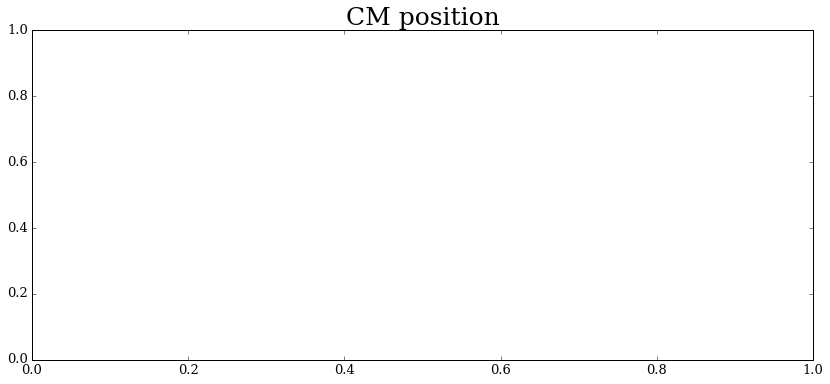

In [42]:
figure(figsize=(14, 13))
subplot(2, 1, 1)
title('CM position', fontsize=25)
plot(Rmwhalo1, Rcm_mwhalo1, lw=2, label='LR', c='k')
plot(Rmwhalo2, Rcm_mwhalo2, lw=3, label='MR', c='k')
plot(Rmwhalo3, Rcm_mwhalo3, lw=4, label='HR', c='k')

plot(RDisk1, Rcm_disk1, lw=2, label='DiskLR', c='b')
plot(RDisk2, Rcm_disk2, lw=3, label='DiskMR', c='b')
plot(RDisk3, Rcm_disk3, lw=4, label='DiskHR', c='b')

xscale('log')
axhline(rcmmwpot1, lw=2, c='k', alpha=0.6)
axhline(RCMHmw1, lw=2, ls='--', c='r', label='LR potential')
axhline(RCMHmw2, lw=3, ls='--', c='r', label='MR potential')
axhline(RCMHmw3, lw=4, ls='--', c='r', label='HR potential')

axhline(RCMDpot1, lw=2, ls='--', c='g', label='LR Disk potential')
axhline(RCMDpot2, lw=3, ls='--', c='g', label='MR Disk potential')
axhline(RCMDpot3, lw=4, ls='--', c='g', label='HR Disk potential')

xlabel('Radius(Kpc)')
ylabel('Kpc')
legend(loc='best',ncol=2 )

subplot(2, 1, 2)
title('CM velocity', fontsize=25)
plot(Rmwhalo1, Vcm_mwhalo1, lw=2, c='k')
plot(Rmwhalo2, Vcm_mwhalo2, lw=3, c='k')
plot(Rmwhalo3, Vcm_mwhalo3, lw=4, c='k')
#plot(RDisk1, Vcm_disk1, lw=2, label='Disk')
#plot(RDisk2, Vcm_disk2, lw=2, label='Disk')
#plot(RDisk3, Vcm_disk3, lw=2, label='Disk')

#axhline(VCMHmw, lw=2, ls='--', label='HR potential')
#axhline(VCMHmwLR, lw=2, ls='--', c='g', label='LR potential')
xlabel('Radius(Kpc)')
ylabel('km/s')
xscale('log')

#axhline(RCMHmw, lw=2, alpha=0.6, c='k')
#axhline(RCMHmwLR, lw=2, alpha=0.6, c='k')
#savefig('CM_comparison.png', bbox_inches='tight')

(128500, 130000)

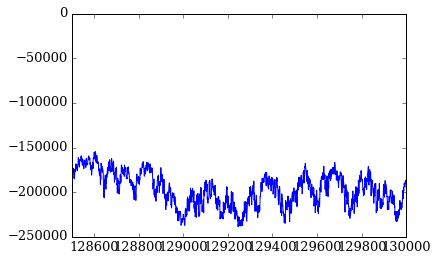

In [289]:
plot(potMWhalo)
xlim(128500, 130000)



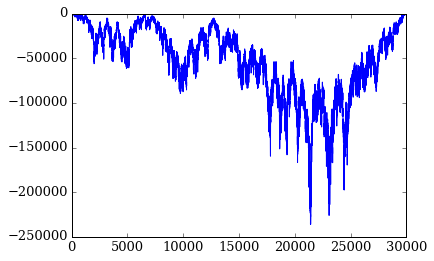

In [256]:
plot(potMWhaloLR)


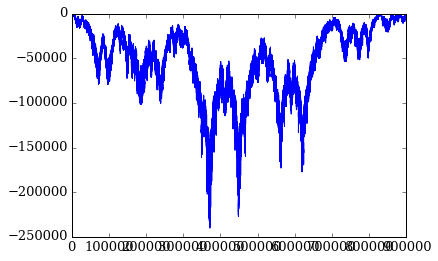

In [72]:
plot(potMWhalo3)


# Poisson Noise

$\dfrac{\sigma_x}{\sqrt{N}}$

following http://adsabs.harvard.edu/abs/2013ApJ...762..109B

In [154]:
def poissonN(x, y, z):
    #R = np.sqrt(x**2 + y**2 + z**2)
    pn = np.zeros(700)
    pn[0] = np.std(x)/ np.sqrt(len(x))
    Xmax = np.zeros(700)
    Xmax[0] = max(abs(x))
    i=0
    while len(x)>3:
        i+=1
        low_s = np.where(abs(x) <= 0.8*max(abs(x)))[0]
        #x = x[low_s]
        x = x[low_s]
        Xmax[i] = max(x)
        pn[i] = np.std(x) / (len(x)**(3.0/2.0)) # is this ok??
        
    index = np.where(pn!=0)[0]
    pn = pn[index]
    min_pn = np.where(pn == min(pn))
    return pn[index], Xmax[index]


In [155]:
PN1, Renclosed1 = poissonN(Xmwhalo1, Ymwhalo1, Zmwhalo1)
PN2, Renclosed2 = poissonN(Xmwhalo2, Ymwhalo2, Zmwhalo2)
PN3, Renclosed3 = poissonN(Xmwhalo3, Ymwhalo3, Zmwhalo3)

In [94]:
print type(Zmwhalo2)

<type 'numpy.ndarray'>


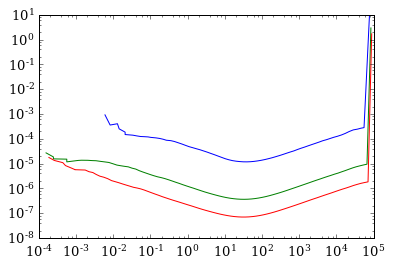

In [153]:
plot(Renclosed1, PN1)
plot(Renclosed2, PN2)
plot(Renclosed3, PN3)
xscale('log')
yscale('log')

In [135]:
print len(PN1)

70
